# Food101

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Configure GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
BATCH_SIZE = 64
TARGET_SIZE = (299, 299)

## Load up the dataset

In [4]:
#!rm -rf /root/.kaggle

In [5]:
# !mkdir /root/.kaggle
# !mv ./kaggle.json /root/.kaggle/kaggle.json
# !chmod 600 /root/.kaggle/kaggle.json
# !kaggle datasets download -d kmader/food41

## Data augmentation
We might not need to augment our data

In [6]:
from keras.preprocessing.image import ImageDataGenerator
SEED = 111
gen_train = ImageDataGenerator(validation_split=0.2, width_shift_range=0.2, height_shift_range=0.2, rotation_range=25, shear_range=0.2, zoom_range=0.2,
                              horizontal_flip=True)
gen_valid = ImageDataGenerator(validation_split=0.2)
train_ds = gen_train.flow_from_directory("./food101/images", target_size=TARGET_SIZE, seed=SEED, subset='training')
valid_ds = gen_valid.flow_from_directory("./food101/images", target_size=TARGET_SIZE, seed=SEED, subset='validation')

class_names = train_ds.class_indices
num_classes = len(train_ds.class_indices)

Found 80800 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.


In [7]:
indices_class = [0 for _ in range(len(class_names))]
for k, v in class_names.items():
    indices_class[v] = k

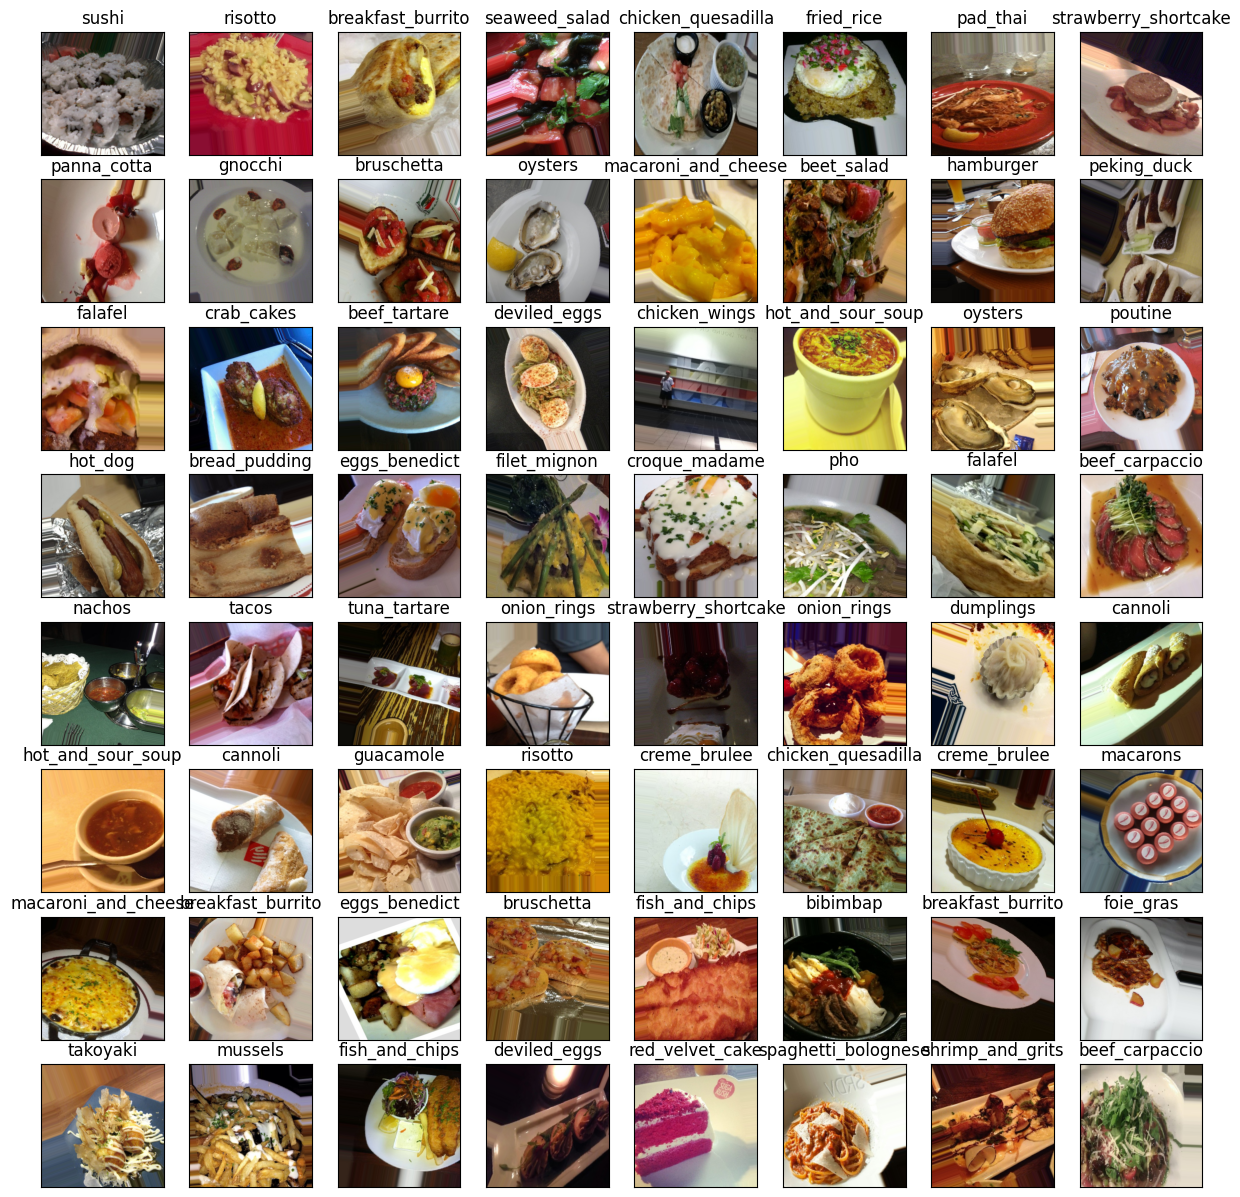

In [8]:
fig = plt.figure(figsize=(15, 15))
cnt = 0
for images, labels in train_ds:
    if cnt >= BATCH_SIZE: break
    ax = plt.subplot(8, 8, cnt + 1)
    ax.imshow(images[0] / 255.0)
    ax.grid(False)
    ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    ax.set_title(indices_class[tf.math.argmax(labels[0], axis=-1)])
    cnt += 1

## Defining the model

In [9]:
from keras.layers import Dense, Conv2D, BatchNormalization, ReLU, MaxPooling2D, GlobalAveragePooling2D, Softmax
from keras.layers import Input, Flatten, Dropout
from keras.optimizers import RMSprop

In [10]:
class Model(keras.models.Model):
    def __init__(self, num_classes):
        super(Model, self).__init__()
        self.num_classes = num_classes

        # Defining the base model
        self.base = keras.applications.EfficientNetB3(include_top=False, drop_connect_rate=0)
        self.base = keras.models.Model(inputs=self.base.inputs, outputs=self.base.output)
        self.base.trainable = False

        # Defining layers
        self.global_avg_pooling = GlobalAveragePooling2D(name='global_average_pooling')
        self.dropout = Dropout(0.3, name='dropout')
        self.classifier = Dense(units=num_classes, name='classifier')

        # Preprocessing
        self.norm = keras.applications.efficientnet.preprocess_input

    def call(self, input_tensor, training=False):
        x = self.norm(input_tensor)
        x = self.base(x, training=training)
        x = self.global_avg_pooling(x)

        if training: x = self.dropout(x)

        x = self.classifier(x)
        return x

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            a = self.call(x, training=True)
            loss = self.compiled_loss(y, a)

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(y, a)

        return {m.name : m.result() for m in self.metrics}

    def build(self, input_shape):
        inputs = Input(shape=input_shape[1:])
        self.model = keras.models.Model(inputs=inputs, outputs=self.call(inputs))
        super(Model, self).build(input_shape)

### Training

In [11]:
model = Model(num_classes)
model.build([None, *TARGET_SIZE, 3])

checkpoint_callback = keras.callbacks.ModelCheckpoint('./checkpoints/', monitor='val_loss', save_weights_only=True, save_best_only=True, verbose=1)

loss = tf.losses.CategoricalCrossentropy(from_logits=True)
optimizer = RMSprop()
metrics = ['accuracy']

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, None, None, 1536)  10783535  
                                                                 
 global_average_pooling (Glo  (None, 1536)             0         
 balAveragePooling2D)                                            
                                                                 
 dropout (Dropout)           multiple                  0 (unused)
                                                                 
 classifier (Dense)          (None, 101)               155237    
                                                                 
 model_2 (Functional)        (None, 101)               10938772  
                                                                 
Total params: 10,938,772
Trainable params: 155,237
Non-trainable params: 10,783,535
___________________________________________

In [12]:
history = model.fit(train_ds, epochs=4, validation_data=valid_ds, callbacks=[checkpoint_callback])

Epoch 1/4
2525/2525 [==============================] - ETA: 0s - loss: 1.6635 - accuracy: 0.5888
Epoch 1: val_loss improved from inf to 1.23216, saving model to ./checkpoints/
2525/2525 [==============================] - 1311s 515ms/step - loss: 1.6635 - accuracy: 0.5888 - val_loss: 1.2322 - val_accuracy: 0.6764
Epoch 2/4
2525/2525 [==============================] - ETA: 0s - loss: 1.2518 - accuracy: 0.6742
Epoch 2: val_loss improved from 1.23216 to 1.17082, saving model to ./checkpoints/
2525/2525 [==============================] - 1291s 511ms/step - loss: 1.2518 - accuracy: 0.6742 - val_loss: 1.1708 - val_accuracy: 0.6920
Epoch 3/4
2525/2525 [==============================] - ETA: 0s - loss: 1.1673 - accuracy: 0.6937
Epoch 3: val_loss did not improve from 1.17082
2525/2525 [==============================] - 1284s 508ms/step - loss: 1.1673 - accuracy: 0.6937 - val_loss: 1.1718 - val_accuracy: 0.6942
Epoch 4/4
2525/2525 [==============================] - ETA: 0s - loss: 1.1270 - accura

## Evaluations

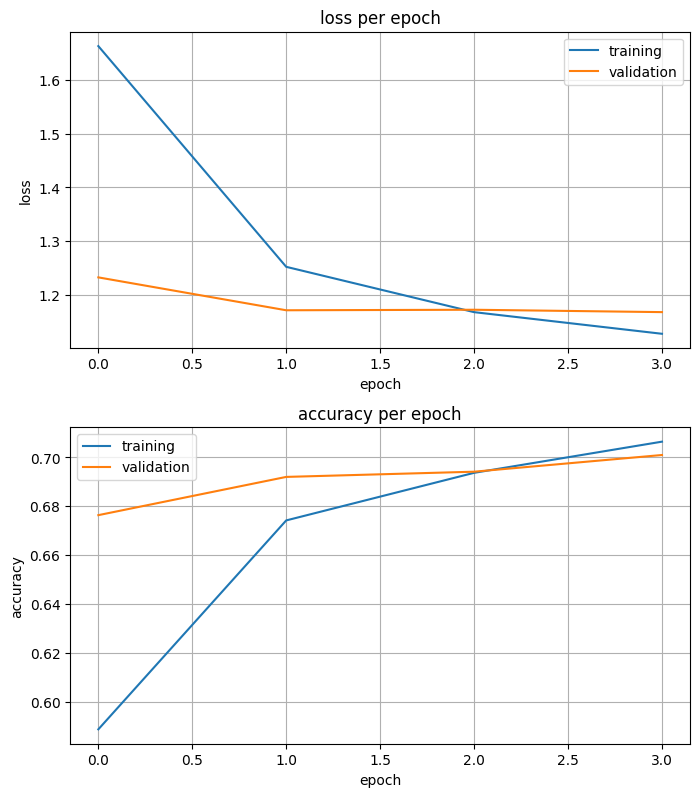

In [13]:
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(2, 1, 1)
ax.plot(history.epoch, history.history['loss'], label='training')
ax.plot(history.epoch, history.history['val_loss'], label='validation')
ax.set_title('loss per epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.grid(True)
ax.legend()

ax = plt.subplot(2, 1, 2)
ax.plot(history.epoch, history.history['accuracy'], label='training')
ax.plot(history.epoch, history.history['val_accuracy'], label='validation')
ax.set_title('accuracy per epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.grid(True)
ax.legend();

fig.subplots_adjust(top=1, hspace=0.25)

In [14]:
y_true = []
y_pred = []

cnt = 0
for images, labels in valid_ds:
    print(f'\r{cnt} out of {valid_ds.n}', end='')
    if cnt >= valid_ds.n:
        break

    y_true.extend(tf.math.argmax(labels, axis=-1).numpy())
    y_pred.extend(tf.math.argmax(model.predict(images, verbose=0), axis=-1).numpy())
    cnt += valid_ds.batch_size

20224 out of 20200

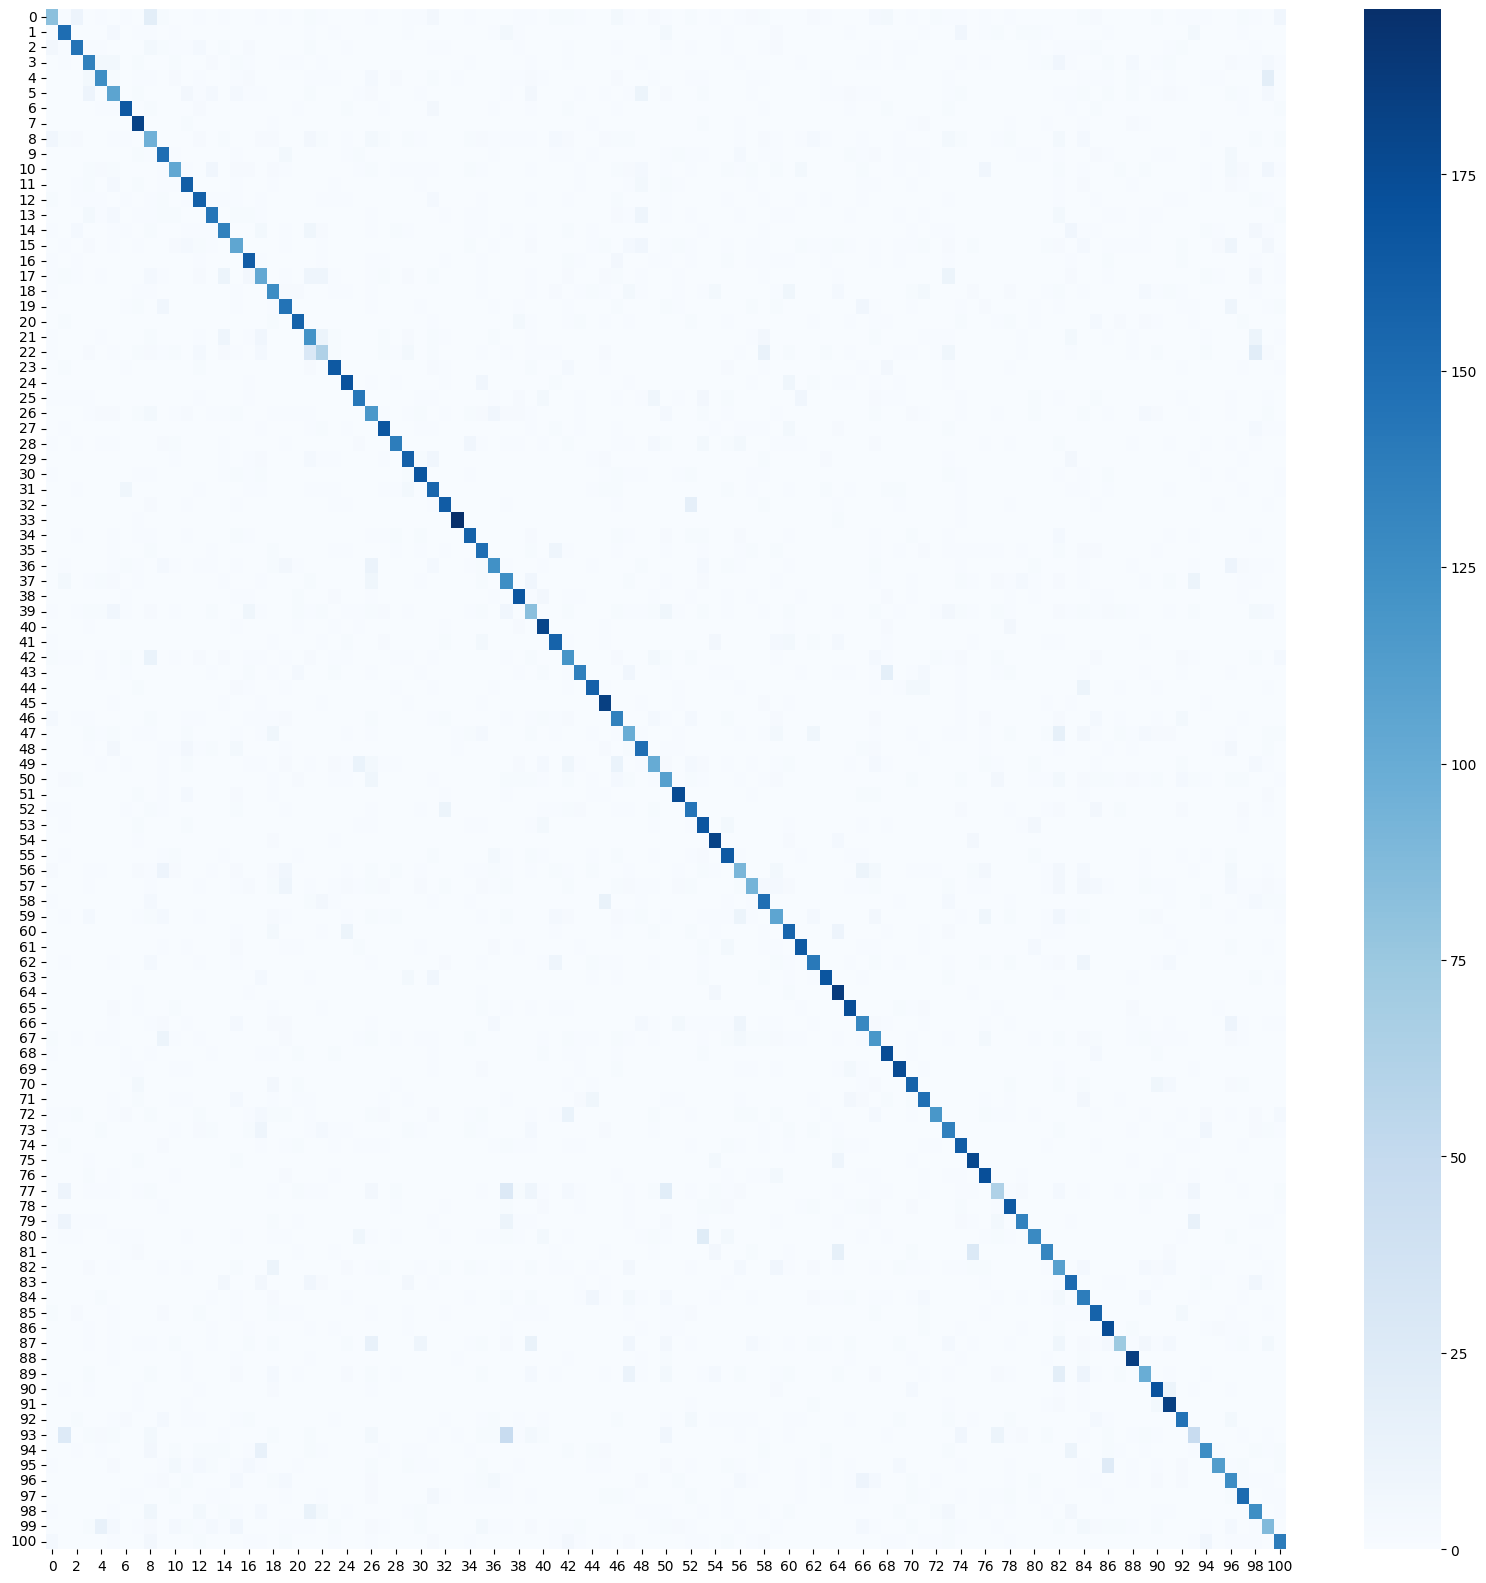

In [15]:
from sklearn.metrics import confusion_matrix, classification_report

fig = plt.figure(figsize=(20, 20))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, cmap="Blues");

In [16]:
print(classification_report(y_true, y_pred, zero_division=True))

              precision    recall  f1-score   support

           0       0.62      0.41      0.49       200
           1       0.65      0.75      0.70       200
           2       0.78      0.72      0.75       200
           3       0.68      0.68      0.68       200
           4       0.70      0.62      0.66       200
           5       0.57      0.54      0.55       200
           6       0.83      0.83      0.83       200
           7       0.76      0.91      0.83       200
           8       0.43      0.48      0.45       200
           9       0.66      0.74      0.70       200
          10       0.67      0.52      0.59       200
          11       0.75      0.81      0.78       200
          12       0.72      0.80      0.76       200
          13       0.78      0.71      0.74       200
          14       0.72      0.68      0.70       200
          15       0.56      0.53      0.54       200
          16       0.73      0.81      0.77       200
          17       0.55    

## Fine Tuning

In [17]:
base_layers = model.layers[0]
for i in range(len(base_layers.layers)):
    print(f"{i:<4} -- {base_layers.layers[i].name}")

0    -- input_1
1    -- rescaling
2    -- normalization
3    -- rescaling_1
4    -- stem_conv_pad
5    -- stem_conv
6    -- stem_bn
7    -- stem_activation
8    -- block1a_dwconv
9    -- block1a_bn
10   -- block1a_activation
11   -- block1a_se_squeeze
12   -- block1a_se_reshape
13   -- block1a_se_reduce
14   -- block1a_se_expand
15   -- block1a_se_excite
16   -- block1a_project_conv
17   -- block1a_project_bn
18   -- block1b_dwconv
19   -- block1b_bn
20   -- block1b_activation
21   -- block1b_se_squeeze
22   -- block1b_se_reshape
23   -- block1b_se_reduce
24   -- block1b_se_expand
25   -- block1b_se_excite
26   -- block1b_project_conv
27   -- block1b_project_bn
28   -- block1b_add
29   -- block2a_expand_conv
30   -- block2a_expand_bn
31   -- block2a_expand_activation
32   -- block2a_dwconv_pad
33   -- block2a_dwconv
34   -- block2a_bn
35   -- block2a_activation
36   -- block2a_se_squeeze
37   -- block2a_se_reshape
38   -- block2a_se_reduce
39   -- block2a_se_expand
40   -- block2a_se_e

In [18]:
fine_tune_at = 353
model.layers[0].trainable = True
for i in range(fine_tune_at):
    model.layers[0].layers[i].trainable = False

for i in range(len(base_layers.layers)):
    if isinstance(base_layers.layers[i], keras.layers.BatchNormalization):
        model.layers[0].layers[i].trainable = False

# Compile
model.summary()

loss = tf.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.optimizers.Adam(learning_rate=1e-4)
metrics = ['accuracy']

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, None, None, 1536)  10783535  
                                                                 
 global_average_pooling (Glo  (None, 1536)             0         
 balAveragePooling2D)                                            
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 classifier (Dense)          (None, 101)               155237    
                                                                 
 model_2 (Functional)        (None, 101)               10938772  
                                                                 
Total params: 10,938,772
Trainable params: 2,074,565
Non-trainable params: 8,864,207
__________________________________________

In [19]:
fine_tune_history = model.fit(train_ds, epochs=5, validation_data=valid_ds, callbacks=[checkpoint_callback])

Epoch 1/5
2525/2525 [==============================] - ETA: 0s - loss: 0.9916 - accuracy: 0.7382
Epoch 1: val_loss improved from 1.16736 to 1.01684, saving model to ./checkpoints/
2525/2525 [==============================] - 1301s 512ms/step - loss: 0.9916 - accuracy: 0.7382 - val_loss: 1.0168 - val_accuracy: 0.7339
Epoch 2/5
2525/2525 [==============================] - ETA: 0s - loss: 0.8351 - accuracy: 0.7730
Epoch 2: val_loss improved from 1.01684 to 0.97859, saving model to ./checkpoints/
2525/2525 [==============================] - 1286s 509ms/step - loss: 0.8351 - accuracy: 0.7730 - val_loss: 0.9786 - val_accuracy: 0.7457
Epoch 3/5
2525/2525 [==============================] - ETA: 0s - loss: 0.7264 - accuracy: 0.7994
Epoch 3: val_loss improved from 0.97859 to 0.97725, saving model to ./checkpoints/
2525/2525 [==============================] - 1282s 508ms/step - loss: 0.7264 - accuracy: 0.7994 - val_loss: 0.9773 - val_accuracy: 0.7486
Epoch 4/5
2525/2525 [=========================

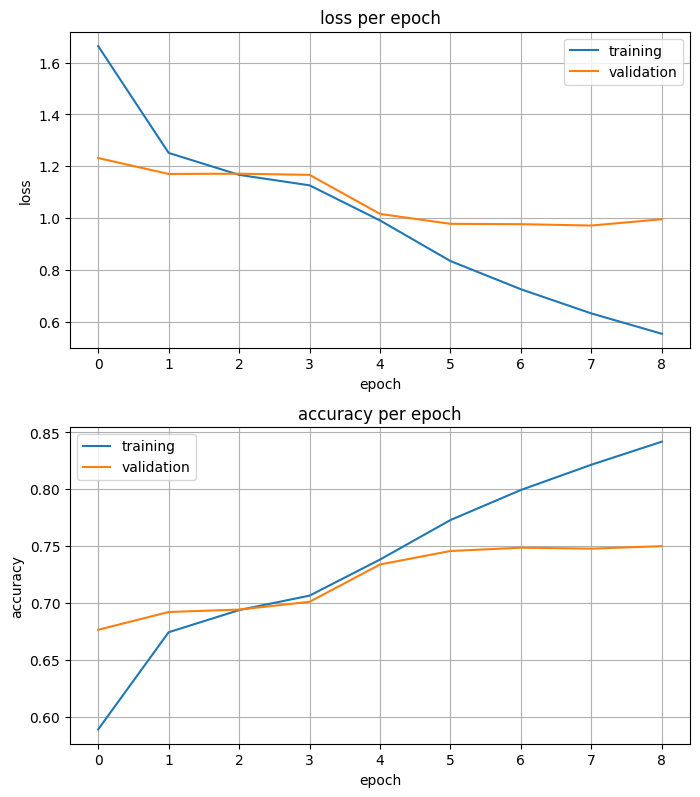

In [20]:
epochs = np.arange(len(history.epoch) + len(fine_tune_history.epoch))
loss = np.hstack((history.history['loss'], fine_tune_history.history['loss']))
valid_loss = np.hstack((history.history['val_loss'], fine_tune_history.history['val_loss']))
acc = np.hstack((history.history['accuracy'], fine_tune_history.history['accuracy']))
valid_acc = np.hstack((history.history['val_accuracy'], fine_tune_history.history['val_accuracy']))

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(2, 1, 1)
ax.plot(epochs, loss, label='training')
ax.plot(epochs, valid_loss, label='validation')
ax.set_title('loss per epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.grid(True)
ax.legend()

ax = plt.subplot(2, 1, 2)
ax.plot(epochs, acc, label='training')
ax.plot(epochs, valid_acc, label='validation')
ax.set_title('accuracy per epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.grid(True)
ax.legend();

fig.subplots_adjust(top=1, hspace=0.25)

In [21]:
y_true = []
y_pred = []

cnt = 0
for images, labels in valid_ds:
    print(f'\r{cnt} out of {valid_ds.n}', end='')
    if cnt >= valid_ds.n:
        break

    y_true.extend(tf.math.argmax(labels, axis=-1).numpy())
    y_pred.extend(tf.math.argmax(model.predict(images, verbose=0), axis=-1).numpy())
    cnt += valid_ds.batch_size

20224 out of 20200

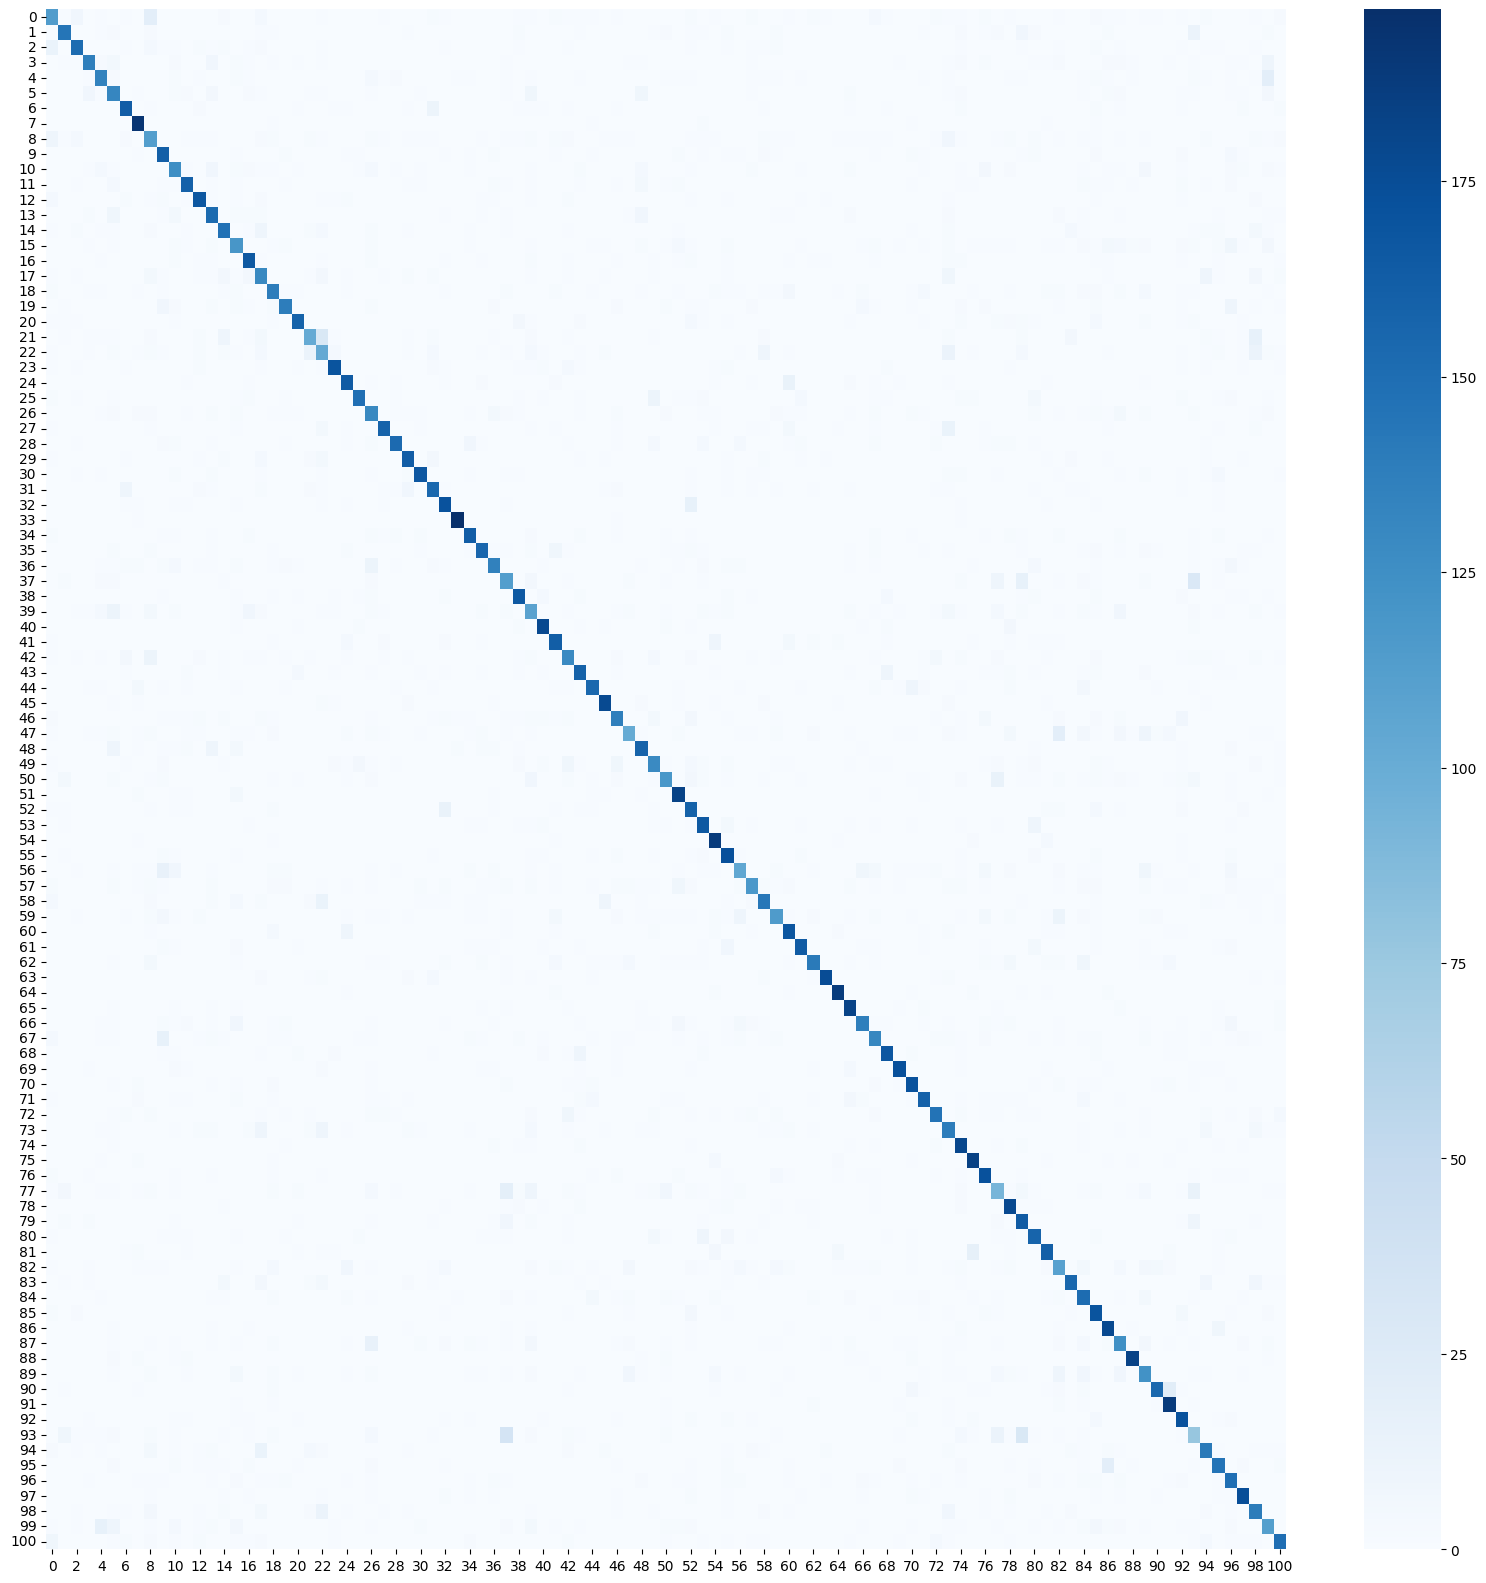

In [22]:
fig = plt.figure(figsize=(20, 20))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, cmap="Blues");

In [23]:
print(classification_report(y_true, y_pred, zero_division=True))

              precision    recall  f1-score   support

           0       0.59      0.57      0.58       200
           1       0.81      0.72      0.76       201
           2       0.83      0.76      0.79       200
           3       0.84      0.69      0.75       200
           4       0.73      0.68      0.70       199
           5       0.57      0.66      0.61       200
           6       0.81      0.81      0.81       200
           7       0.83      0.96      0.89       200
           8       0.51      0.56      0.54       200
           9       0.67      0.81      0.73       200
          10       0.64      0.63      0.63       199
          11       0.84      0.80      0.82       200
          12       0.82      0.83      0.82       201
          13       0.68      0.76      0.72       201
          14       0.77      0.74      0.75       199
          15       0.60      0.60      0.60       200
          16       0.79      0.83      0.81       199
          17       0.58    

## Summary